In [1]:
import numpy as np
from skimage import io, img_as_float

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import os
import math
import librosa
import matplotlib.pyplot as plt

### **Do Not Run** - Converter script
This is only for demonstration purposes and to show how the different sound files were processed to obtain the mel spectrogram images.

This also shows how the different mood tags were drawn from the valence/arousal values in the DEAM dataset.

In [ ]:
import os

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm


def to_mood(valence, arousal):
    if(valence >= 1 and valence <= 5 and arousal >= 1 and arousal <= 5):
        return "sad"
    elif(valence >= 1 and valence < 5 and arousal > 5 and arousal <= 9):
        return "scarry"
    elif(valence >= 5 and valence <= 9 and arousal >= 5 and arousal <= 9):
        return "happy"
    elif(valence > 5 and valence <= 9 and arousal >= 1 and arousal < 5):
        return "calm"
    else:
        return "neutral"

def song_to_mood(id):
    valence = -1
    arousal = -1
    for s in df.iloc:
        if s[0] == id:
            valence = s[1]
            arousal = s[3]
            break
    
    if(not valence == -1):
        return to_mood(valence, arousal)

#df = pd.read_csv('B:/Desktop/DEAM_Data/DEAM_Annotations/annotations.csv')


######### Enter the path to the test song #########
#
path = 'B:/Desktop/GTZAN_Data/genres_original'
image_path = 'B:/Desktop/GTZAN_Data/images_new/'
#
###################################################


id = 0

genre_path = os.listdir(path)
for genre in tqdm(genre_path, desc=" Genre loop", position=0):

    song_path = os.listdir(path+'/'+genre)
    for song in tqdm(song_path, desc=" Songs loop", position=1, leave=False):

        data, sr = librosa.load(path+'/'+genre+'/'+song)

        mel_spec = librosa.feature.melspectrogram(y=data, sr=sr)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)


        # Resize image to the size used in the GTZAN dataset (432x288)
        fig, ax = plt.subplots(figsize=(4.32,2.88))

        # Display melspec on figure's axis to hide them
        img = librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='hz', hop_length=512, sr=sr, ax=ax)

        # Remove axis to get a nice clean image
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel(None)
        ax.set_xlabel(None)

        # Get the song's mood
        #mood = song_to_mood(int(song.replace('.mp3', '')))

        # Save image
        plt.savefig(image_path+genre+'/'+str(id)+'.png')
        plt.close(fig)

        id += 1

# **Dataset loading**

### Extract melspectrogram images for music genres & mood

In [2]:
# This is to extract the melspec images from the GTZAN and DEAM datasets as to only store them during runtime
!unzip /content/drive/MyDrive/Colab/AudioCW/GenreImages.zip -d /content/GenreImage

!unzip /content/drive/MyDrive/Colab/AudioCW/MoodImages.zip -d /content/MoodImage

Archive:  /content/drive/MyDrive/Colab/AudioCW/GenreImages.zip
  inflating: /content/GenreImage/blues/0.png  
  inflating: /content/GenreImage/blues/1.png  
  inflating: /content/GenreImage/blues/10.png  
  inflating: /content/GenreImage/blues/11.png  
  inflating: /content/GenreImage/blues/12.png  
  inflating: /content/GenreImage/blues/13.png  
  inflating: /content/GenreImage/blues/14.png  
  inflating: /content/GenreImage/blues/15.png  
  inflating: /content/GenreImage/blues/16.png  
  inflating: /content/GenreImage/blues/17.png  
  inflating: /content/GenreImage/blues/18.png  
  inflating: /content/GenreImage/blues/19.png  
  inflating: /content/GenreImage/blues/2.png  
  inflating: /content/GenreImage/blues/20.png  
  inflating: /content/GenreImage/blues/21.png  
  inflating: /content/GenreImage/blues/22.png  
  inflating: /content/GenreImage/blues/23.png  
  inflating: /content/GenreImage/blues/24.png  
  inflating: /content/GenreImage/blues/25.png  
  inflating: /content/GenreI

### Utility functions for labels and datasets

In [3]:
# Utility functions to go from a genre/mood to its class and vice-versa
genre_class = {"blues" : 0, "classical" : 1, "country" : 2, "disco" : 3, "hiphop" : 4, "jazz" : 5, "metal" : 6, "pop" : 7, "reggae" : 8, "rock" : 9}

mood_class = {"happy" : 0, "sad" : 1, "scarry" : 2, "calm" : 3}

# --------------------------
def genre_to_class(genre):
  for g in genre_class:
    if(g == genre):
      return genre_class[genre]

def class_to_genre(gClass):
  for g in genre_class:
    if(genre_class[g] == gClass):
      return g

# --------------------------

def mood_to_class(mood):
  for m in mood_class:
    if(m == mood):
      return mood_class[m]

def class_to_mood(mClass):
  for m in mood_class:
    if(mood_class[m] == mClass):
      return m
# --------------------------


# PyTorch custom dataset to use through a DataLoader and make processing easier
class GenreDataset(Dataset):
  def __init__(self, data, labels, transform=None, target_transform=None):
    self.data = data
    self.labels = labels
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    image = self.data[idx]
    label = self.labels[idx]
        
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

### Create & split training and validation sets

##### Genre set creation

In [4]:
# Define genre training and validation sets (1 missing because of a corrupted jazz file (#54))
genre_train_data = np.zeros((899, 3, 223, 337))
genre_train_label = np.zeros((899))

genre_valid_data = np.zeros((100, 3, 223, 337))
genre_valid_label = np.zeros((100))


train_i = 0
valid_i = 0

# Load image data from the GenreImage folder and labels from each image's subfolder
image_path = os.listdir('/content/GenreImage')
for genre in image_path:

  # Index to split the dataset into 90% - 10% (train - validation sets / Test is the audio case study)
  idx = 0

  genre_path = os.listdir('/content/GenreImage/'f'{genre}')
  for item in genre_path:

    # Read image
    img = img_as_float(io.imread('/content/GenreImage/'+genre+"/"+item))

    # Crop image to reduce the amount of useless data (final size should be 217x335)
    # -----------------------------------------------
    # Select all pixels almost equal to white (use of tolerance because of fading between colors)
    white = np.array([1, 1, 1, 1])
    mask = np.abs(img - white).sum(axis=2) < 0.05

    # Find the bounding box of those pixels
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    # Crop image
    img = img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
    # -----------------------------------------------

    # Discard useless alpha channel
    img = img[:,:,:3]

    # Switch channels arround for the model to process
    img = np.moveaxis(img, -1, 0)

    idx+=1

    if(idx <= 10):
      genre_valid_data[valid_i] = img
      genre_valid_label[valid_i] = genre_to_class(genre)
      valid_i += 1
    else:
      genre_train_data[train_i] = img
      genre_train_label[train_i] = genre_to_class(genre)
      train_i += 1


# Display the shape of each set to make sure everything's alright
print("Training set shape:   "f'{genre_train_data.shape}')
print("Validation set shape: "f'{genre_valid_data.shape}')

Training set shape:   (899, 3, 223, 337)
Validation set shape: (100, 3, 223, 337)


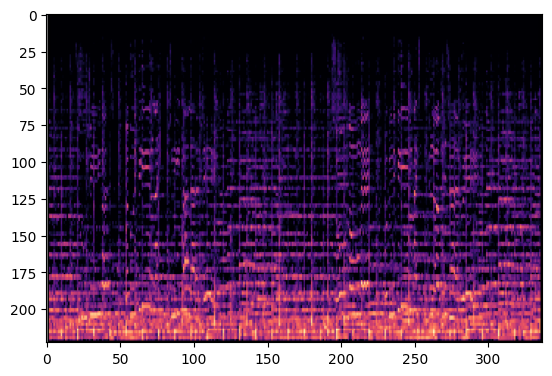

rock


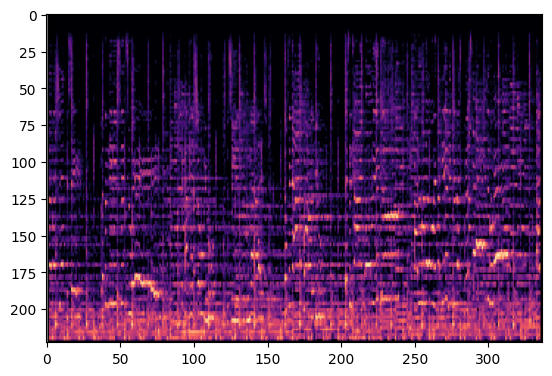

rock


In [5]:
# Display last image of each set (manually instead of -1) to make sure everything is correctly stored.
plt.imshow(np.moveaxis(genre_train_data[898], 0, -1))
plt.show()
print(class_to_genre(genre_train_label[898]))

plt.imshow(np.moveaxis(genre_valid_data[99], 0, -1))
plt.show()
print(class_to_genre(genre_valid_label[99]))

##### Mood set creation

In [6]:
# Define mood training and validation sets
mood_train_data = np.zeros((720, 3, 223, 337))
mood_train_label = np.zeros((720))

mood_valid_data = np.zeros((80, 3, 223, 337))
mood_valid_label = np.zeros((80))


train_i = 0
valid_i = 0

# Load image data from the MoodImage folder and labels from each image's subfolder
image_path = os.listdir('/content/MoodImage')
for mood in image_path:

  # Index to split the dataset into 90% - 10% (train - validation sets / Test is the audio case study)
  idx = 0

  mood_path = os.listdir('/content/MoodImage/'f'{mood}')
  for item in mood_path:

    # Read image
    img = img_as_float(io.imread('/content/MoodImage/'+mood+"/"+item))

    # Crop image to reduce the amount of useless data (final size should be 217x335)
    # -----------------------------------------------
    # Select all pixels almost equal to white (use of tolerance because of fading between colors)
    white = np.array([1, 1, 1, 1])
    mask = np.abs(img - white).sum(axis=2) < 0.05

    # Find the bounding box of those pixels
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    # Crop image
    img = img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
    # -----------------------------------------------

    # Discard useless alpha channel
    img = img[:,:,:3]

    # Switch channels arround for the model to process
    img = np.moveaxis(img, -1, 0)

    idx+=1

    if(idx <= 20):
      mood_valid_data[valid_i] = img
      mood_valid_label[valid_i] = mood_to_class(mood)
      valid_i += 1
    else:
      mood_train_data[train_i] = img
      mood_train_label[train_i] = mood_to_class(mood)
      train_i += 1


# Display the shape of each set to make sure everything's alright
print("Training set shape:   "f'{mood_train_data.shape}')
print("Validation set shape: "f'{mood_valid_data.shape}')

Training set shape:   (720, 3, 223, 337)
Validation set shape: (80, 3, 223, 337)


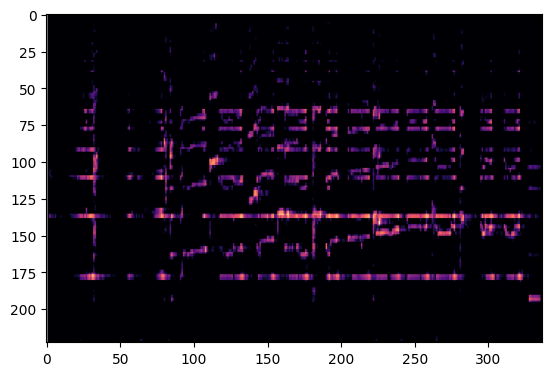

sad


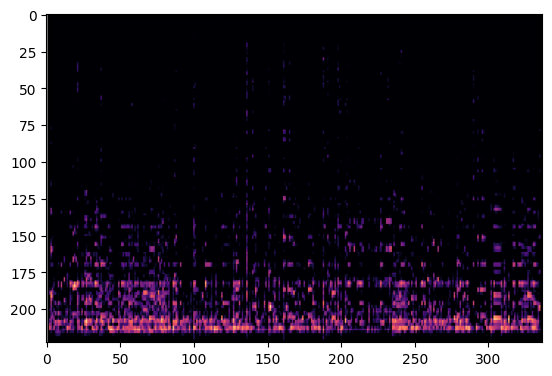

sad


In [7]:
# OPTIONAL - Display is quite big so only run to check or screen the melspecs
#
# Display last image of each set (manually instead of -1) to make sure everything is correctly stored.
plt.imshow(np.moveaxis(mood_train_data[719], 0, -1))
plt.show()
print(class_to_mood(mood_train_label[719]))

plt.imshow(np.moveaxis(mood_valid_data[79], 0, -1))
plt.show()
print(class_to_mood(mood_valid_label[79]))

##### Test audio initial loading

In [8]:
# Read test audio image
test_file = img_as_float(io.imread('/content/Calm_Classical_Guitar.png'))

# Crop image to reduce the amount of useless data (final size should be 223x337)
# -----------------------------------------------
# Select all pixels almost equal to white (use of tolerance because of fading between colors)
white = np.array([1, 1, 1, 1])
mask = np.abs(test_file - white).sum(axis=2) < 0.05

# Find the bounding box of those pixels
coords = np.array(np.nonzero(~mask))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

# Crop image
test_file = test_file[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
# -----------------------------------------------

# Discard useless alpha channel
test_file = test_file[:,:,:3]

# Switch channels arround for the model to process
test_file = np.moveaxis(test_file, -1, 0)

### Create training and validation datasets

In [13]:
# Convert numpy arrays to torch tensors
genre_train_data = torch.from_numpy(genre_train_data)
genre_valid_data = torch.from_numpy(genre_valid_data)

genre_train_label = torch.from_numpy(genre_train_label)
genre_valid_label = torch.from_numpy(genre_valid_label)


mood_train_data = torch.from_numpy(mood_train_data)
mood_valid_data = torch.from_numpy(mood_valid_data)

mood_train_label = torch.from_numpy(mood_train_label)
mood_valid_label = torch.from_numpy(mood_valid_label)

In [14]:
# Create custom PyTorch datasets to make training and mini-batching easier
genre_train_dataset = GenreDataset(genre_train_data, genre_train_label)
genre_valid_dataset = GenreDataset(genre_valid_data, genre_valid_label)

mood_train_dataset = GenreDataset(mood_train_data, mood_train_label)
mood_valid_dataset = GenreDataset(mood_valid_data, mood_valid_label)


# Create DataLoaders from datasets
genre_train_dataloader = DataLoader(genre_train_dataset, batch_size=10, shuffle=True)
genre_valid_dataloader = DataLoader(genre_valid_dataset, batch_size=10, shuffle=True)

mood_train_dataloader = DataLoader(mood_train_dataset, batch_size=10, shuffle=True)
mood_valid_dataloader = DataLoader(mood_valid_dataset, batch_size=10, shuffle=True)



# Make sure datasets have been loaded correctly by printing one batch
train_features, train_labels = next(iter(genre_train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10, 3, 223, 337])
Labels batch shape: torch.Size([10])


# **Model 1 - Simple CNN**

### Define CNN model & evaluation function

In [93]:
class SimpleCnnModel(nn.Module):
    """The CNN model"""
    def __init__(self, num_classes):
        
        super(SimpleCnnModel, self).__init__()
        
        # Different convolutional layers to be used
        # Each starts with a convolutional layer followed by a max pooling layer and a ReLU activation function
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=0), 
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
      
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=0), 
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        
        self.conv3 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=0), 
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        
        self.conv4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0), 
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        

        # Fully connected layers
        self.fc_layers = nn.Sequential(nn.Linear(16640, 512),
                                       nn.Dropout(0.5),
                                       nn.ReLU(),

                                       nn.Linear(512, num_classes),
                                       nn.Softmax(dim=1))

    def forward(self, x):

        # Process through convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Flatten tensor
        x = torch.flatten(x, start_dim=1)

        # Process through fully connected layer
        x = self.fc_layers(x)

        return x

In [17]:
# Evaluation function to check accuracy on a given dataset
def evaluate(model, dataLoader):
  total, correct = 0, 0
  
  # Good practice to turn on evaluate mode
  model.eval()

  with torch.no_grad():
    for data in dataLoader:

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs.float())

      _, pred = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (pred == labels).sum().item()

  return 100 * correct / total



# Weight initialization function using Xavier Uniform distribution
def weights_init(m):
    # Use same weight init. for both linear and convolutional layers
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

### Define CNN model and training block for **genre** classification

In [94]:
# Training statistics storing block
# This allows to run the block below multiple times without losing info about previous epochs
# Run this block to reset them
train_loss = []
train_acc = []
valid_acc = []

In [95]:
# Determine device on which to run calculations
device = torch.device("cuda:0")


# Declare CNN network with 10 classes and send it to cuda device for computing
simple_genre_model = SimpleCnnModel(10).to(device)

# Init. all of the model's weights using Xavier Uniform distribution.
simple_genre_model.apply(weights_init)

# Cross-entropy loss is one of the best for classification problems
criterion = nn.CrossEntropyLoss().to(device)


# Adam Optimizer, learning rate 0.0001 with weight decay to reduce overfitting (weight decay basically uses L2 regularization in pytorch for the adam optimizer)
optimizer = torch.optim.Adam(simple_genre_model.parameters(), lr=1e-4, weight_decay=1e-6)


def train_genre(num_epochs):
  for epoch in range(num_epochs):

    running_loss = 0

    # Loop over batches
    for data in genre_train_dataloader:

      simple_genre_model.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the gradients and pass inputs through CNN
      optimizer.zero_grad()
      outputs = simple_genre_model(inputs.float())

      # Compute loss
      loss = criterion(outputs, labels.long())
      
      # Compute gradients and update paramaters using optimizer's algorithm (Adam here)
      loss.backward()
      optimizer.step()

      # Add batch loss to this epoch's training loss
      running_loss += loss.item()

    # Append values to read later
    train_loss.append(running_loss)
    train_acc.append(evaluate(simple_genre_model, genre_train_dataloader))
    valid_acc.append(evaluate(simple_genre_model, genre_valid_dataloader))

    print("Epoch {} loss: {}, train_acc: {}, valid_acc: {}".format(epoch+1, train_loss[-1], train_acc[-1], valid_acc[-1]))

Epoch 1 loss: 150.5973744392395, train_acc: 85.20578420467186, valid_acc: 63.0
Epoch 2 loss: 151.22401130199432, train_acc: 86.4293659621802, valid_acc: 63.0
Epoch 3 loss: 150.1405336856842, train_acc: 87.65294771968854, valid_acc: 58.0
Epoch 4 loss: 149.18858802318573, train_acc: 87.43047830923248, valid_acc: 63.0
Epoch 5 loss: 148.8997391462326, train_acc: 89.09899888765295, valid_acc: 59.0
Epoch 6 loss: 146.63936388492584, train_acc: 89.65517241379311, valid_acc: 61.0
Epoch 7 loss: 145.86391139030457, train_acc: 90.98998887652948, valid_acc: 60.0
Epoch 8 loss: 145.584308385849, train_acc: 90.87875417130145, valid_acc: 59.0
Epoch 9 loss: 144.6791651248932, train_acc: 91.65739710789767, valid_acc: 65.0
Epoch 10 loss: 143.76019310951233, train_acc: 92.21357063403782, valid_acc: 64.0
Epoch 11 loss: 143.59593975543976, train_acc: 92.54727474972191, valid_acc: 63.0
Epoch 12 loss: 141.86148476600647, train_acc: 93.32591768631814, valid_acc: 61.0
Epoch 13 loss: 142.04868876934052, train_acc

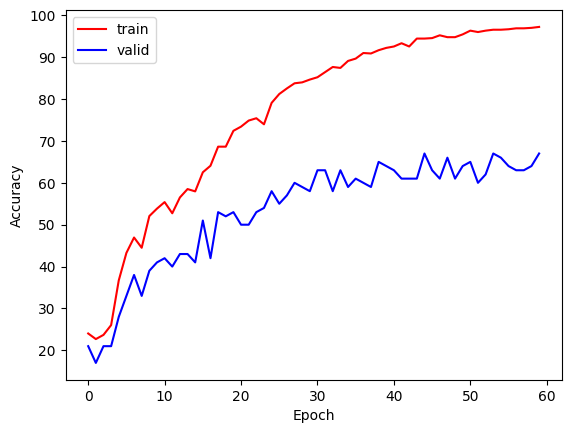

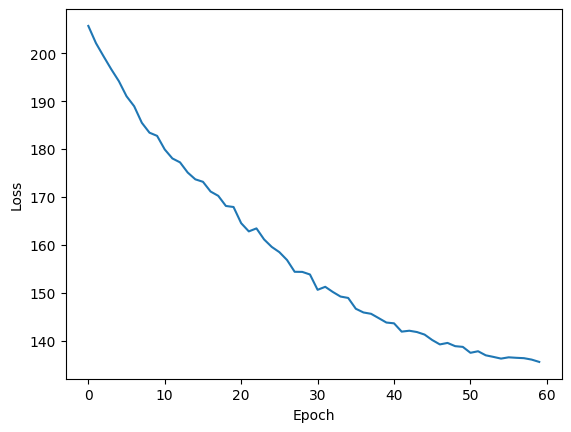

In [97]:
# TRAINING BLOCK - Run multiple times to continue training.
num_epochs = 30


# Start training loop
train_genre(num_epochs)

# Plot graph of train and test accuracies over epochs
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc, "r")
plt.plot(valid_acc, "b")
plt.gca().legend(('train','valid'))
plt.show()

# Plot graph of training loss over epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

In [98]:
# Useful to print a model summary
from torchvision import models
from torchsummary import summary

summary(simple_genre_model.cuda(), (3, 223, 337))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 336]             208
         MaxPool2d-2         [-1, 16, 111, 168]               0
              ReLU-3         [-1, 16, 111, 168]               0
            Conv2d-4         [-1, 32, 110, 167]           2,080
         MaxPool2d-5           [-1, 32, 55, 83]               0
              ReLU-6           [-1, 32, 55, 83]               0
            Conv2d-7           [-1, 32, 54, 82]           4,128
         MaxPool2d-8           [-1, 32, 27, 41]               0
              ReLU-9           [-1, 32, 27, 41]               0
           Conv2d-10           [-1, 64, 26, 40]           8,256
        MaxPool2d-11           [-1, 64, 13, 20]               0
             ReLU-12           [-1, 64, 13, 20]               0
           Linear-13                  [-1, 512]       8,520,192
          Dropout-14                  [

### Load case study audio and test for **genre**

In [99]:
# Convert to torch tensor and continue processing from here (Can only be done here since we want to pass it through the cuda device for faster processing (not essential but still nice))
test_audio = torch.from_numpy(test_file)

test_audio = test_audio.to(device)
test_audio = test_audio.float()

# Just to make sure its fine
print(test_audio.shape)

# Get prediction from test audio and print its predicted genre
prediction = simple_genre_model(test_audio.unsqueeze(0))
_, pred = torch.max(prediction, 1)

print("Genre prediction: "+class_to_genre(pred))

torch.Size([3, 223, 337])
Genre prediction: jazz


### Define CNN model and training block for **mood** classification

In [100]:
# Training statistics storing block
# This allows to run the block below multiple times without losing info about previous epochs
# Run this block to reset them
train_loss = []
train_acc = []
valid_acc = []

In [101]:
simple_mood_model = SimpleCnnModel(4).to(device)  # Declare CNN network with 4 classes and send it to cuda device for computing
simple_mood_model.apply(weights_init)             # Init. all of the model's weights using Xavier Uniform distribution.


# Cross-entropy loss is one of the best for classification problems
criterion = nn.CrossEntropyLoss().to(device)

# Adam Optimizer, learning rate 0.0001 with weight decay to reduce overfitting
optimizer = torch.optim.Adam(simple_mood_model.parameters(), lr=1e-4, weight_decay=1e-6)


def train_mood(num_epochs):
  for epoch in range(num_epochs):

    running_loss = 0

    # Loop over batches
    for data in mood_train_dataloader:

      simple_mood_model.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the gradients and pass inputs through CNN
      optimizer.zero_grad()
      outputs = simple_mood_model(inputs.float())

      # Compute loss
      loss = criterion(outputs, labels.long())
      
      # Compute gradients and update paramaters using optimizer's algorithm (Adam here)
      loss.backward()
      optimizer.step()

      # Add batch loss to this epoch's training loss
      running_loss += loss.item()


    # Append values to read later
    train_loss.append(running_loss)
    train_acc.append(evaluate(simple_mood_model, mood_train_dataloader))
    valid_acc.append(evaluate(simple_mood_model, mood_valid_dataloader))

    print("Epoch {} loss: {}, train_acc: {}, valid_acc: {}".format(epoch+1, train_loss[-1], train_acc[-1], valid_acc[-1]))

Epoch 1 loss: 79.36656129360199, train_acc: 71.38888888888889, valid_acc: 50.0
Epoch 2 loss: 78.59112173318863, train_acc: 73.33333333333333, valid_acc: 51.25
Epoch 3 loss: 77.02843928337097, train_acc: 69.30555555555556, valid_acc: 47.5
Epoch 4 loss: 77.00346231460571, train_acc: 74.58333333333333, valid_acc: 47.5
Epoch 5 loss: 76.93991529941559, train_acc: 72.63888888888889, valid_acc: 51.25
Epoch 6 loss: 75.36990749835968, train_acc: 73.19444444444444, valid_acc: 45.0
Epoch 7 loss: 75.19107896089554, train_acc: 77.5, valid_acc: 42.5
Epoch 8 loss: 74.92650777101517, train_acc: 78.05555555555556, valid_acc: 46.25
Epoch 9 loss: 73.51629281044006, train_acc: 80.97222222222223, valid_acc: 47.5
Epoch 10 loss: 73.56234383583069, train_acc: 79.30555555555556, valid_acc: 50.0
Epoch 11 loss: 72.45292335748672, train_acc: 81.25, valid_acc: 50.0
Epoch 12 loss: 72.64510941505432, train_acc: 82.36111111111111, valid_acc: 53.75
Epoch 13 loss: 70.44665682315826, train_acc: 83.19444444444444, valid_

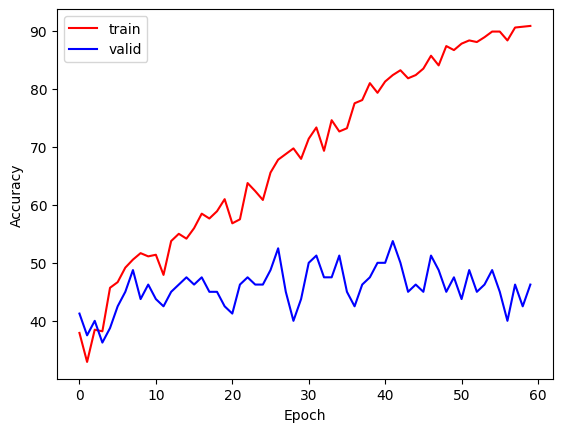

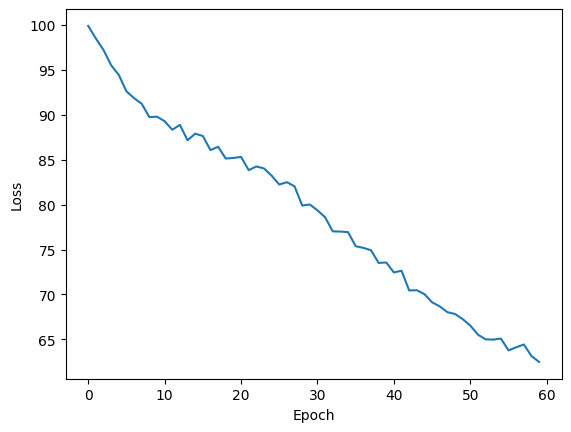

In [103]:
# TRAINING BLOCK - Run multiple times to continue training.
num_epochs = 30


# Start training loop
train_mood(num_epochs)


# Plot graph of train and test accuracies over epochs
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc, "r")
plt.plot(valid_acc, "b")
plt.gca().legend(('train','valid'))
plt.show()

# Plot graph of training loss over epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

### Load case study audio and test for **mood**

In [104]:
# Convert to torch tensor and continue processing from here
test_audio = torch.from_numpy(test_file)

test_audio = test_audio.to(device)
test_audio = test_audio.float()

# Get prediction from test audio and print its predicted genre
prediction = simple_mood_model(test_audio.unsqueeze(0))
_, pred = torch.max(prediction, 1)

print("Mood prediction: "+class_to_mood(pred))

Mood prediction: sad


# **Model 2 - Pretrained CNN (ResNet18)**

### Define pretrained model for classification of either genre or mood

In [22]:
class PretrainedModel(nn.Module):
    """The CNN model"""
    def __init__(self, num_classes):
        
        super(PretrainedModel, self).__init__()
        
        # Pretrained model
        self.trained_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Fully connected layers
        self.fc_layers = nn.Sequential(nn.Linear(1000, 64),
                                       nn.Dropout(0.8),
                                       nn.ReLU(),

                                       nn.Linear(64, num_classes),
                                       nn.Softmax(dim=1))

    def forward(self, x):

        # Process through ResNet model
        x = self.trained_model(x)

        # Process through fully connected layers
        x = self.fc_layers(x)

        return x

In [23]:
# Training statistics storing block
# This allows to run the block below multiple times without losing info about previous epochs
# Run this block to reset them
train_loss = []
train_acc = []
valid_acc = []

In [24]:
# Determine device on which to run calculations
device = torch.device("cuda:0")

pretrained_model = PretrainedModel(4).to(device)


# Cross-entropy loss is one of the best for classification problems
criterion = nn.CrossEntropyLoss().to(device)

# Adam Optimizer, learning rate 1e-4 and weight decay of 1e-5
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.0001, weight_decay=0.00001)


def train_loop(num_epochs):
  for epoch in range(num_epochs):

    running_loss = 0

    # Loop over batches
    for data in mood_train_dataloader:

      pretrained_model.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the gradients and pass inputs through CNN
      optimizer.zero_grad()
      outputs = pretrained_model(inputs.float())

      # Compute loss
      loss = criterion(outputs, labels.long())
      
      # Compute gradients and update paramaters using optimizer's algorithm (Adam here)
      loss.backward()
      optimizer.step()

      # Add batch loss to this epoch's training loss
      running_loss += loss.item()

    # Append values to read later
    train_loss.append(running_loss)
    train_acc.append(evaluate(pretrained_model, mood_train_dataloader))
    valid_acc.append(evaluate(pretrained_model, mood_valid_dataloader))

    print("Epoch {} loss: {}, train_acc: {}, valid_acc: {}".format(epoch+1, train_loss[-1], train_acc[-1], valid_acc[-1]))

Epoch 1 loss: 72.70313543081284, train_acc: 82.91666666666667, valid_acc: 50.0
Epoch 2 loss: 73.36874014139175, train_acc: 71.80555555555556, valid_acc: 50.0
Epoch 3 loss: 78.16410881280899, train_acc: 73.19444444444444, valid_acc: 46.25
Epoch 4 loss: 74.49261808395386, train_acc: 78.88888888888889, valid_acc: 43.75
Epoch 5 loss: 72.88963961601257, train_acc: 82.08333333333333, valid_acc: 47.5
Epoch 6 loss: 74.55213832855225, train_acc: 77.08333333333333, valid_acc: 37.5
Epoch 7 loss: 73.42944079637527, train_acc: 82.63888888888889, valid_acc: 52.5
Epoch 8 loss: 72.27351659536362, train_acc: 81.25, valid_acc: 56.25
Epoch 9 loss: 73.91231948137283, train_acc: 82.22222222222223, valid_acc: 46.25
Epoch 10 loss: 71.20734649896622, train_acc: 85.55555555555556, valid_acc: 55.0


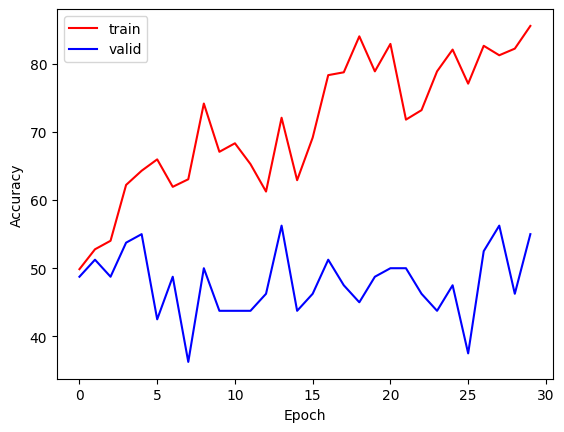

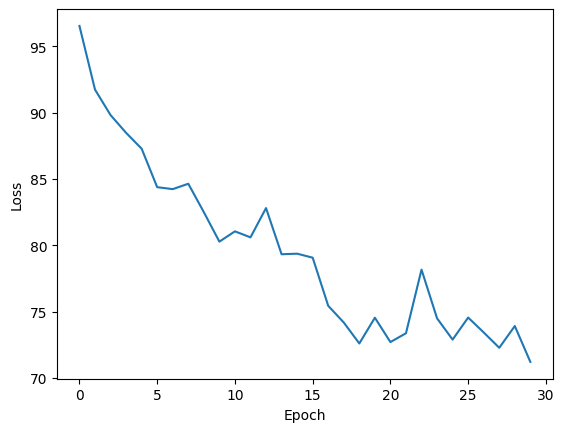

In [26]:
# TRAINING BLOCK - Run multiple times to continue training.
num_epochs = 10


# Start training loop for GENRE classification
train_loop(num_epochs)


# Plot graph of train and test accuracies over epochs
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc, "r")
plt.plot(valid_acc, "b")
plt.gca().legend(('train','valid'))
plt.show()

# Plot graph of training loss over epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

In [27]:
# Convert to torch tensor and continue processing from here (Can only be done here since we want to pass it through the cuda device for faster processing (not essential but still nice))
test_audio = torch.from_numpy(test_file)

test_audio = test_audio.to(device)
test_audio = test_audio.float()

# Get prediction from test audio and print its predicted genre
prediction = pretrained_model(test_audio.unsqueeze(0))
_, pred = torch.max(prediction, 1)

print("Prediction: "+class_to_mood(pred))

Prediction: scarry


### Define pretrained model for multi-output classification of genre & mood

In [28]:
class MultiModel(nn.Module):
    """The CNN model"""
    def __init__(self):
        
        super(MultiModel, self).__init__()
        
        # Pretrained model
        self.trained_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Fully connected layers
        self.fc_layers1 = nn.Sequential(nn.Linear(1000, 128),
                                       nn.Dropout(0.7),
                                       nn.ReLU(),

                                       nn.Linear(128, 10),
                                       nn.Softmax(dim=1))
        
        self.fc_layers2 = nn.Sequential(nn.Linear(1000, 64),
                                       nn.Dropout(0.8),
                                       nn.ReLU(),

                                       nn.Linear(64, 4),
                                       nn.Softmax(dim=1))

    def forward(self, x):

        # Process through ResNet model
        x = self.trained_model(x)
        
        # Flatten tensor
        #x = torch.flatten(x, start_dim=1)

        # Process through fully connected layers
        genre = self.fc_layers1(x)
        mood = self.fc_layers2(x)

        return genre, mood

In [29]:
# Multi-output evaluation function to check accuracy on 2 datasets
def evaluate_multi(model, dataLoader1, dataLoader2):
  total, correct = 0, 0
  
  # Good practice to turn on evaluate mode
  model.eval()

  with torch.no_grad():
    # Check accuracy for first inference
    for data in dataLoader1:

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs, _ = model(inputs.float())

      _, pred = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (pred == labels).sum().item()
    
    # Check accuracy for second inference
    for data in dataLoader2:

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      _, outputs = model(inputs.float())

      _, pred = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (pred == labels).sum().item()

  return 100 * correct / total

In [30]:
# Training statistics storing block
# This allows to run the block below multiple times without losing info about previous epochs
# Run this block to reset them
train_loss = []
train_acc = []
valid_acc = []

In [31]:
multi_model = MultiModel().to(device)


# Declare loss function.
# Cross-entropy loss is one of the best for classification problems
criterion = nn.CrossEntropyLoss().to(device)

# Adam Optimizer, learning rate 0.001
optimizer = torch.optim.Adam(multi_model.parameters(), lr=0.00001, weight_decay=0.000001)


def train_loop(num_epochs):
  for epoch in range(num_epochs):

    running_loss = 0

    # Loop over genre batches
    for data in genre_train_dataloader:

      multi_model.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the gradients and pass inputs through CNN
      optimizer.zero_grad()
      outputs = multi_model(inputs.float())

      # Compute loss
      loss = criterion(outputs[0], labels.long())
      
      # Compute gradients and update paramaters using optimizer's algorithm
      loss.backward()
      optimizer.step()

      # Add batch loss to this epoch's training loss
      running_loss += loss.item()


    # Loop over mood batches
    for data in mood_train_dataloader:

      multi_model.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = multi_model(inputs.float())

      loss = criterion(outputs[1], labels.long())

      loss.backward()
      optimizer.step()

      running_loss += loss.item()


    # Append values to read later
    train_loss.append(running_loss)
    train_acc.append(evaluate_multi(multi_model, genre_train_dataloader, mood_train_dataloader))
    valid_acc.append(evaluate_multi(multi_model, genre_valid_dataloader, mood_valid_dataloader))

    print("Epoch {} loss: {}, train_acc: {}, valid_acc: {}".format(epoch+1, train_loss[-1], train_acc[-1], valid_acc[-1]))

Epoch 1 loss: 223.35022121667862, train_acc: 89.19085855466338, valid_acc: 58.888888888888886
Epoch 2 loss: 220.26903158426285, train_acc: 90.30265596046942, valid_acc: 57.77777777777778
Epoch 3 loss: 217.19607436656952, train_acc: 90.92032118591723, valid_acc: 58.888888888888886
Epoch 4 loss: 215.1951224207878, train_acc: 91.47621988882025, valid_acc: 56.666666666666664
Epoch 5 loss: 213.91232186555862, train_acc: 92.83508338480543, valid_acc: 60.0
Epoch 6 loss: 212.69925546646118, train_acc: 92.89684990735022, valid_acc: 58.333333333333336
Epoch 7 loss: 211.1711842417717, train_acc: 93.8851142680667, valid_acc: 55.55555555555556
Epoch 8 loss: 208.7478192448616, train_acc: 94.93514515132799, valid_acc: 58.888888888888886
Epoch 9 loss: 206.2339837551117, train_acc: 95.61457689932057, valid_acc: 58.333333333333336
Epoch 10 loss: 206.56259143352509, train_acc: 96.29400864731316, valid_acc: 57.77777777777778


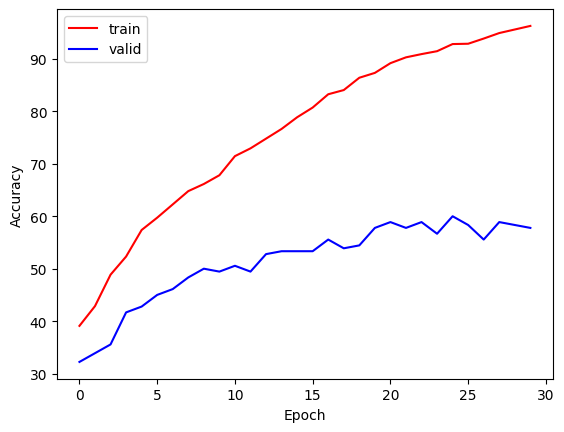

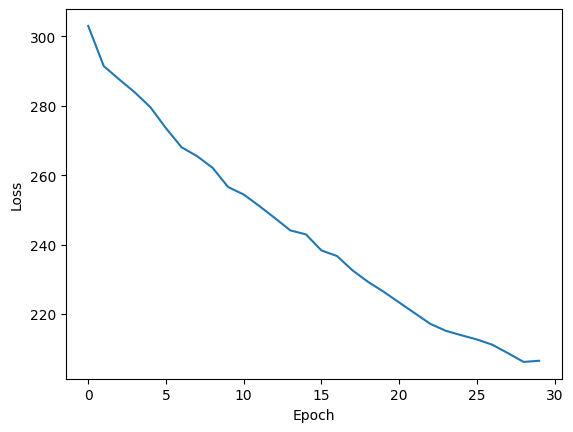

In [33]:
# TRAINING BLOCK - Run multiple times to continue training.
num_epochs = 10


# Start training loop
train_loop(num_epochs)


# Plot graph of train and test accuracies over epochs
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc, "r")
plt.plot(valid_acc, "b")
plt.gca().legend(('train','valid'))
plt.show()

# Plot graph of training loss over epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

In [34]:
# Convert to torch tensor and continue processing from here (Can only be done here since we want to pass it through the cuda device for faster processing (not essential but still nice))
test_audio = torch.from_numpy(test_file)

test_audio = test_audio.to(device)
test_audio = test_audio.float()

# Get prediction from test audio and print its predicted genre
prediction = multi_model(test_audio.unsqueeze(0))
_, genre = torch.max(prediction[0], 1)
_, mood = torch.max(prediction[1], 1)

print("Genre: "+class_to_genre(genre)+" - Mood: "+class_to_mood(mood))

Genre: classical - Mood: sad
